In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [2]:
def readFile_cryo(filename):
    timeTickFirst, timeTickLast, x, PMT1, PMT1_raw, PMT1_bottom, PMT1_top, PMT2, PMT2_raw, PMT2_bottom, PMT2_top \
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, skiprows=0,unpack=True)
    return x, PMT1

In [3]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, \
    ion4_top, ion5, ion5_raw, ion5_bottom, ion5_top \
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, skiprows=0,unpack=True, encoding='latin1')
    return x, ion3

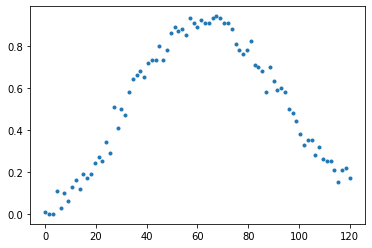

In [4]:
xb, BSB = readFile('time_scan_counter_prop_rfsoc_001')
plt.plot(xb, BSB, '.')

## Define Hamiltonian

In [5]:
times = xb
nMax = 20

In [13]:
def H(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B+H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

### Test the Hamiltonian

(0, 1)

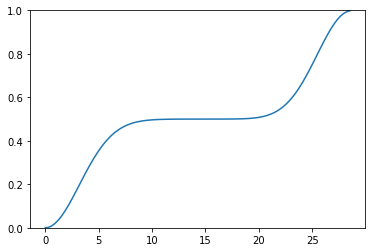

In [18]:
xb = np.linspace(0, 28.5, 101)
H0 = []
n0 = 0.0
etaOmega = 0.05*np.pi*2
count = 0
for t in xb:
    H0.append(H(n0, False, 10*10**(-6), etaOmega, [0,t])[-1]) # Test Blue sideband
    
plt.plot(xb,H0)
plt.ylim([0,1])

## Curve fit

In [12]:
def Red(x, n0, etaOmega):
    return H(n0, True, 0, etaOmega, x)
def Blue(x, n0, etaOmega):
    return H(n0, False, 0, etaOmega, x)

def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/100)+0.005)
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/100)+0.005)
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    plt.show()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])

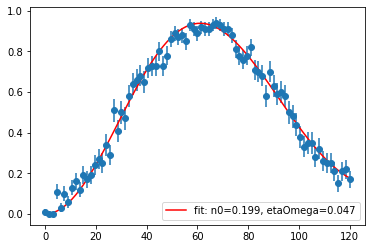

[0.19899561 0.04745554]
0.018157600762772112


In [15]:
### Test fit: BSB
xdata = xb
ydata = BSB
guess = np.array([0.4, 0.05])
BSB_fit = FitBlue(xdata, ydata, guess)

The loop fitting doesn't work well because it's highly sensitive to the initial guess (expecially the `etaOmega` parameter). If needed we have to change the guess value mannually.

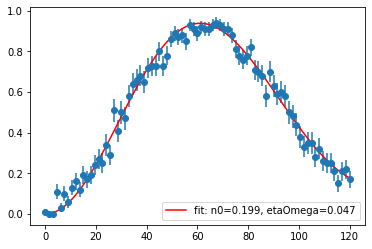

[0.19899905 0.04745552]
0.018157172728262536


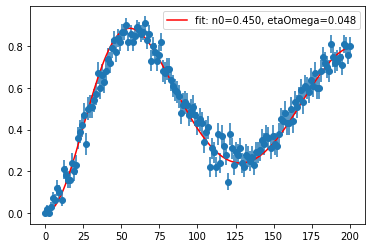

[0.45024963 0.04784124]
0.018896730655888202


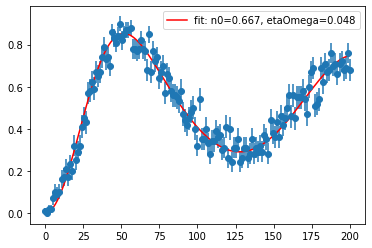

[0.66672855 0.04803993]
0.02723669447213186


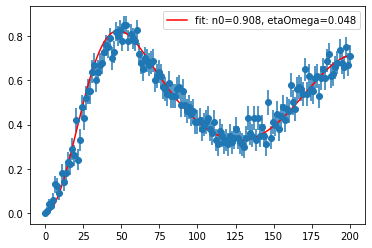

[0.90801884 0.04831559]
0.0344061418420121


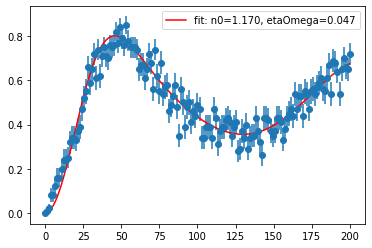

[1.17038523 0.0474254 ]
0.05145704783427833


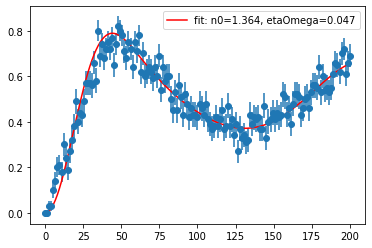

[1.36441989 0.04716904]
0.062174828647405735


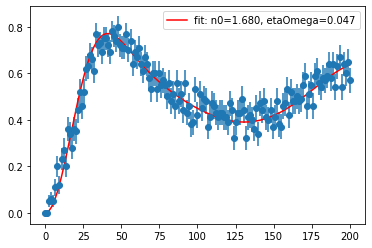

[1.68037286 0.04737778]
0.07095555323823528


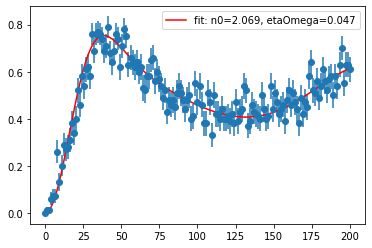

[2.0693249  0.04708818]
0.10296567735266555


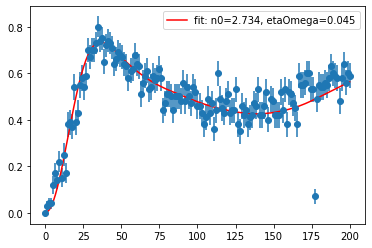

[2.73361807 0.04476818]
0.2423264516716324


In [16]:
ls = np.linspace(1,17,9)
ns = []
errs = []
for l in ls:
    filename = 'time_scan_counter_prop_rfsoc_'+str(int(l)).zfill(3)
    xb, BSB = readFile(filename)
    guess = np.array([0.1, 0.05])
    BSB_fit, nerr= FitBlue(xb, BSB, guess)
    ns.append(BSB_fit[0])
    errs.append(nerr)

## Define heating rate fit

In [17]:
def Heating(x, a, b):
    return a * x + b
def heatingFit(xdata, ydata,yerr):
    popt, pcov = curve_fit(Heating, xdata, ydata, sigma=yerr)
    print(r'Heating rate = '+str(popt[0])+r'$\pm$'+str(np.sqrt(np.diag(pcov)[0]))+r' quanta/s ')
    print('Intersept = '+str(popt[1])+r'$\pm$'+str(np.sqrt(np.diag(pcov)[1]))+' quanta')
    fitY = [Heating(x, popt[0], popt[1]) for x in xdata]
    'fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt)
    plt.plot(xdata, Heating(xdata,*popt), 'grey')
    plt.errorbar(xdata, ydata, yerr,ls='',marker='o',mec='firebrick',ecolor='firebrick',mfc='pink')
    plt.text(0,2.8, r'Heating rate = '+str(round(popt[0],3))+r' $\pm$ '+str(round(np.sqrt(np.diag(pcov)[0]),3))+r' q/s')
    plt.xlabel('Time (s)')
    plt.ylabel('Motional quanta')
    plt.show()

Heating rate = 477.3801029229058$\pm$6.571518791295241 quanta/s 
Intersept = 0.20165554014134543$\pm$0.0072092457188360805 quanta


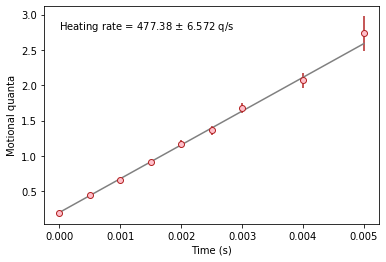

In [18]:
T = np.array([0, 0.5e-3, 1e-3, 1.5e-3, 2e-3, 2.5e-3, 3e-3, 4e-3, 5e-3])
pp = heatingFit(T, ns, errs)